<a target="_blank" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/070_correlation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

(correlation-causation-notebook)=
# Correlazione e causazione

In questo capitolo, ci addentreremo nel complesso mondo della correlazione e della causalità, due concetti che, benché strettamente connessi, rimangono distinti nell'analisi dei dati. La correlazione misura la forza e la direzione dell'associazione lineare tra due variabili, ma non implica necessariamente una relazione causale tra di esse. Esploreremo come la correlazione possa manifestarsi in diverse strutture causali quali il Fork, il Pipe, il Collider e i Descendents, evidenziando come possa risultare talvolta ingannevole. Comprendere questi aspetti è fondamentale per interpretare correttamente i dati ed evitare errori comuni, come la confusione tra correlazione e causalità. Attraverso l'analisi di indici statistici come la covarianza e l'esplorazione dell'effetto dei confounders, ci avventureremo oltre la mera analisi bivariata, sondando le complesse dinamiche che guidano le relazioni tra le variabili.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import arviz as az
import graphviz
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

## Correlazione non implica causalità

È fondamentale ricordare che la correlazione rappresenta un indice descrittivo della relazione lineare tra due variabili e non può essere utilizzata per trarre conclusioni sulle relazioni causali tra le variabili. L'espressione ben nota *correlazione non implica causalità* sottolinea questo concetto importante. Un esempio illustrativo delle correlazioni spurie può essere trovato sul sito [spurious correlations](https://tylervigen.com/spurious-correlations).

### Definizione di causalità

La causalità costituisce un elemento cruciale nella ricerca, poiché molte delle domande che cerchiamo di risolvere riguardano le relazioni causali tra le variabili. Quando ci riferiamo alla causalità, impieghiamo una serie di termini che denotano come una variabile possa influenzare un'altra. Questi termini includono parole come "causa," "influenza," "l'effetto di su," "aumenta/decrese," "cambia," "porta a," "determina," "scatena," "migliora," "è responsabile di," e altri simili. Questi termini si distinguono da un linguaggio descrittivo mediante il quale possiamo esaminare le relazioni tra le variabili senza necessariamente implicare la causalità, utilizzando espressioni come "sono associati," "sono correlati," "sono connessi," "tendono a verificarsi insieme," "tendono a non verificarsi insieme," "vanno insieme," e analoghe.

Anche se non esiste una definizione univoca di causalità, per gli scopi presenti possiamo dire che una variabile X causa un effetto Y se, intervenendo e modificando il valore di X, la distribuzione di Y subisce una modifica in risposta a questa variazione. È importante dunque sottolineare che la causalità è un concetto probabilistico. Ciò implica che anche se il cambiamento in X non sempre determina in modo rigido un cambiamento in Y, ma piuttosto altera la probabilità che Y si verifichi, continuiamo a ritenere che X causa Y. In altre parole, la causalità è intrinsecamente legata alle probabilità e non a relazioni deterministiche.

### Dati osservazionali

Nonostante la maggior parte dei ricercatori sia consapevole che gli esperimenti randomizzati siano considerati il "metodo d'elezione" per l'inferenza causale, in psicologia la manipolazione della variabile indipendente di interesse spesso si rivela impraticabile, eticamente discutibile o semplicemente impossibile. Per esempio, non è etico o praticabile assegnare casualmente bambini a diverse "esperienze di vita", anche se potremmo essere interessati a comprendere le possibili conseguenze negative delle avversità infantili sulla salute mentale in età adulta.

Tuttavia, è possibile condurre analisi causali "deboli" basandosi sui dati osservazionali. Uno degli strumenti utilizzati per sviluppare ipotesi causali basate su dati osservazionali sono i "DAG" (Grafi Aciclici Diretti), che forniscono rappresentazioni visive delle relazioni causali ipotizzate. Questi grafi sono stati principalmente sviluppati da Judea Pearl (Pearl, 1995) e condividono molte caratteristiche con i modelli di Equazioni Strutturali (SEM). Essi sono utili per rispondere a domande come: quali variabili dovrebbero essere controllate? Quali variabili possono essere trascurate? E in quali situazioni l'introduzione del controllo statistico influenzerà negativamente l'analisi causale? Il controllo di una variabile implica l'inclusione di questa variabile nel modello causale al fine di isolare gli effetti causali di interesse.

Un modo per comprendere i DAG è interpretarli come modelli strutturali non parametrici (SEMs) (Elwert, 2013). Mentre gli SEMs codificano assunzioni sulla forma della relazione tra le variabili (di default, le frecce negli SEMs indicano relazioni lineari e additive), una freccia in un DAG potrebbe riflettere una relazione che segue qualsiasi forma funzionale (ad esempio, polinomiale, esponenziale, sinusoidale o a gradini). In questo senso, un DAG è qualitativo: $A \rightarrow B$ significa solo che A influisce causalmente su B in qualche modo.

Inoltre, a differenza degli SEMs, i DAGs consentono solo frecce unidirezionali, motivo per cui sono definiti come grafi diretti. Talvolta può essere necessario rappresentare l'associazione tra due variabili che non sono causalmente collegate ma condividono una causa comune non specificata, indicata come U. Nei SEMs, questo viene indicato da una doppia freccia ($A \leftrightarrow B$). Invece, nei DAGs, tale situazione è rappresentata come $A \leftarrow U \rightarrow B$.

#### Percorsi e strutture casuali elementari

Da questi due semplici elementi costitutivi, ossia nodi e frecce, è possibile visualizzare situazioni più complesse e seguire percorsi tra variabili. Attraverso un DAG, è possibile individuare vari percorsi seguendo le frecce da un nodo all'altro. Anche se tali percorsi possono diventare arbitrariamente lunghi e complessi, possono essere categorizzati in tre strutture causali elementari.

**Le catene.** Le catene sono rappresentate dalla struttura A $\rightarrow$ B $\rightarrow$ C.

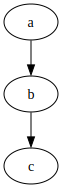

In [30]:
f = graphviz.Digraph()
f.edge("A", "B")
f.edge("B", "C")
f

**Le biforcazioni.** Le biforcazioni sono descritte dalla struttura A $\leftarrow$ B $\rightarrow$ C;

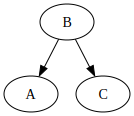

In [31]:
f = graphviz.Digraph()
f.edge("B", "A")
f.edge("B", "C")
f

**Le biforcazioni invertite.** Le biforcazioni invertite sono caratterizzate dalla struttura A $\rightarrow$ B $\leftarrow$ C.

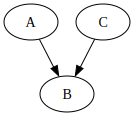

In [32]:
f = graphviz.Digraph()
f.edge("A", "B")
f.edge("C", "B")
f

Queste tre strutture causali di base determinano le caratteristiche dei percorsi più estesi. Un percorso composto esclusivamente da catene, come ad esempio intelligenza $\rightarrow$ voti $\rightarrow$ titolo di studio $\rightarrow$ reddito, può trasmettere un'associazione causale. Lungo una catena di questo tipo, le variabili direttamente o indirettamente influenzate causalmente da una determinata variabile sono chiamate *discendenti*, mentre le variabili che influenzano direttamente o indirettamente una data variabile sono considerate i suoi *antenati*.

Un percorso che contiene anche delle biforcazioni, come titolo di studio $\leftarrow$ voti $\leftarrow$ intelligenza $\rightarrow$ reddito, trasmette comunque un'associazione, ma non rappresenta più una relazione causale a causa dell'introduzione di una variabile di confondimento (in questo caso, l'intelligenza).

Invece, un percorso che presenta una biforcazione invertita è bloccato e non trasmette alcuna associazione. Ad esempio, il percorso titolo di studio $\rightarrow$ reddito $\leftarrow$ intelligenza $\rightarrow$ voti non implica una correlazione tra titolo di studio e voti.

I DAG sono detti aciclici perché non consentono percorsi ciclici in cui le variabili diventano loro stesse antenate. Nei DAG una variabile non può influenzare causalmente se stessa.

### Variabili di confondimento

Con una comprensione dei termini centrali e delle regole dei DAG, ritorniamo ora ai dati osservazionali. Il problema centrale dei dati osservazionali è il *confondimento*, ossia la presenza di una causa comune che si cela dietro alla potenziale causa di interesse (la variabile indipendente; in contesti sperimentali, spesso chiamata trattamento) e all'outcome di interesse (la variabile dipendente). Tale influenza da parte del confondimento può introdurre quella che spesso viene chiamata una *correlazione spuria*, la quale non dovrebbe essere confusa con un effetto causale.

Facciamo ora una simulazione che chiarisce il concetto di correlazione spuria. Denotiamo con `c` una variabile di confondimento.

In [58]:
c = np.random.rand(100)

Nella simulazione, le variabili `x` e `y` sono indipendenti tra di loro dal punto di vista causale, ma entrambe sono influenzate dalla variabile `c`. Come abbiamo visto in precedenza, questa struttura casuale corrisponde ad una "biforcazione" nel DAG.

In [59]:
x = c + .1 * np.random.rand(100)
y = c + .3 * np.random.rand(100)

Esaminiamo ora la correlazione tra `a` e `c`.

In [60]:
coef, p_val = stats.pearsonr(x, y)
print(coef)

0.9529015661709993


In altre parole, anche se le variabili `x` e `y`  sono causalmente indipendenti, la presenza di una terza variabile `c` (variabile di confondimento) che le influenza entrambe fa sì che `x` e `y` risultino correlate tra di loro. Questo è un esempio di correlazione spuria.

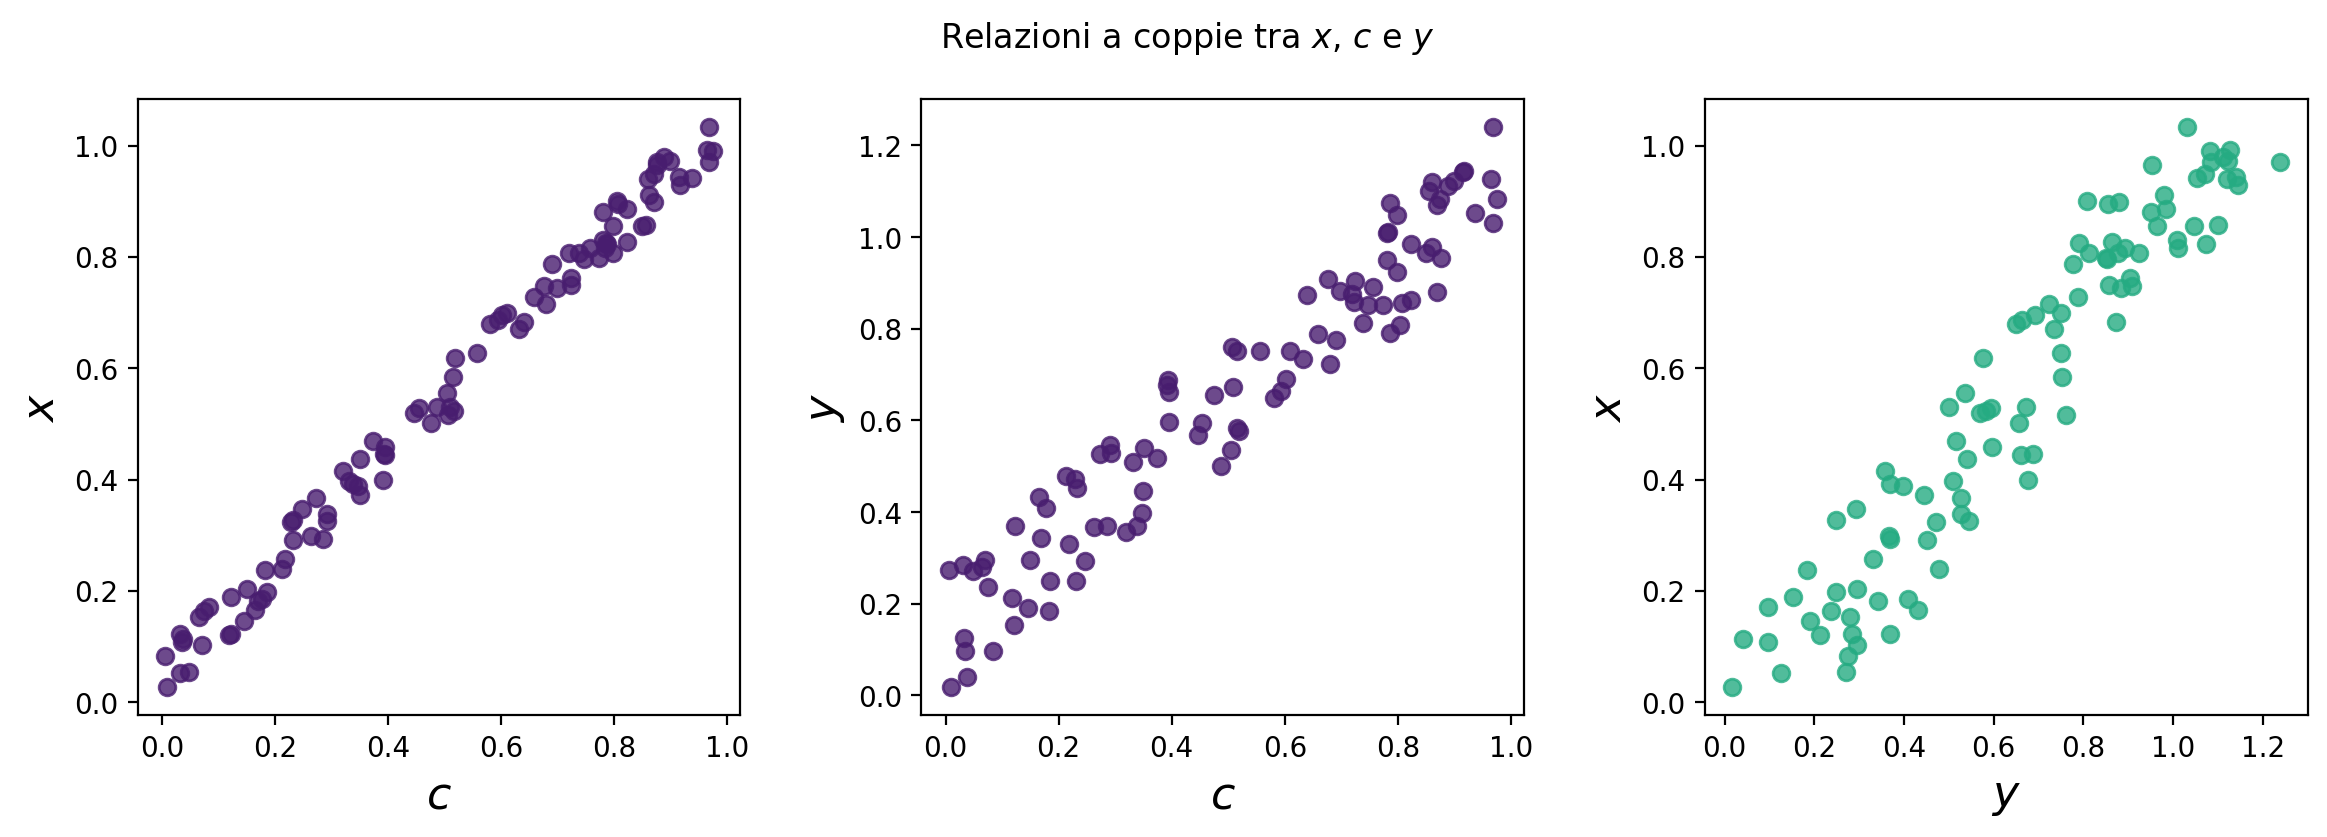

In [63]:
# Il codice è tratto da A. Molak (2023) "Causal Inference and Discovery in Python".

COLORS = ["C0", "C2"]

variables = {"x": x, "c": c, "y": y}

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, (var_1, var_2) in enumerate([("c", "x"), ("c", "y"), ("y", "x")]):
    color = COLORS[1]

    if "c" in [var_1, var_2]:
        color = COLORS[0]

    ax = axes[i]
    ax.scatter(variables[var_1], variables[var_2], alpha=0.8, color=color)

    ax.set_xlabel(f"${var_1}$", fontsize=16)
    ax.set_ylabel(f"${var_2}$", fontsize=16)

plt.suptitle("Relazioni a coppie tra $x$, $c$ e $y$")
plt.subplots_adjust(wspace=0.3)
plt.show()


In conclusione, quando osserviamo l'associazione tra due variabili, $X$ e $Y$, una tale associazione potrebbe non essere una conseguenza della diretta relazione causale tra $X$ e $Y$, ma piuttosto un effetto di una terza variabile, in questo caso $C$, che è una "causa comune" per entrambe.

### Back-doors

Dopo aver costruito un DAG, è possibile identificare i percorsi del "back-door". I percorsi back-door sono tutti i percorsi che iniziano con una freccia che punta alla variabile indipendente e terminano con una freccia che punta alla variabile dipendente. In altre parole, i percorsi back-door indicano che potrebbe esserci un fattore comune che influisce sia sul trattamento sia sull'outcome. I percorsi back-door sono problematici quando trasmettono un'associazione. In questo caso, i percorsi back-door consistono in una biforcazione (cioè non ci sono biforcazioni invertite, che bloccherebbero qualsiasi associazione trasmessa). Di conseguenza, questi percorsi back-door sono aperti e possono trasmettere un'associazione spuria. Per eliminare questa indesiderata associazione non causale, è necessario bloccare i percorsi back-door.

Un modo per farlo è attraverso la stratificazione. Quando riconosciamo la presenza di una causa comune e stratifichiamo l'analisi per $Z$ (cioè dividiamo l'analisi in gruppi o strati in base ai livelli di $Z$), l'apparente associazione tra $X$ e $Y$ scompare. Questo dimostra che non esiste una relazione causale diretta tra $X$ e $Y$, ma che l'associazione era dovuta all'influenza comune di $Z$ su entrambe le variabili.


### Confounders fondamentali

Poniamoci ora il problema di esaminare come la correlazione si manifesta all'interno di diverse strutture causali, quali il Fork, il Pipe, il Collider e i Descendents. Analizzeremo la correlazione tra due variabili in questi diversi contesti mettendo in luce l'effetto che i confounders possono avere su di essa.

Nelle strutture causali menzionate, vedremo come la correlazione possa talvolta risultare ingannevole. Ad esempio, nel caso del Collider, la correlazione può emergere o scomparire a causa della stratificazione di una variabile che risente dell'influenza di entrambe le variabili di interesse. Allo stesso modo, i Descendents, cioè le variabili che sono influenzate da altre all'interno della catena causale, possono alterare la percezione delle relazioni tra le variabili.

Questi fenomeni sottolineano l'importanza di una comprensione accurata dei confounders, in particolare quelli fondamentali, che devono essere esaminati attentamente nell'analisi. In sintesi, la correlazione, benché sia uno strumento descrittivo potente, deve essere interpretata con cautela, specialmente quando si tratta di trarre deduzioni sulle complesse relazioni causali che possono celarsi dietro una semplice analisi bivariata.

#### Biforcazione

In un diagramma causale, una biforcazione rappresenta una struttura specifica in cui una variabile comune causa due o più variabili figlie. Ad esempio, se abbiamo una variabile $Z$ che causa sia $X$ che $Y$, questo può essere rappresentato come una biforcazione nella struttura del diagramma. La biforcazione può essere un punto cruciale nell'analisi, poiché la comprensione delle relazioni tra le variabili a questo punto può aiutare a discernere le vere relazioni causali.

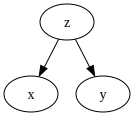

In [12]:
f = graphviz.Digraph()
f.edge("z", "x")
f.edge("z", "y")
f

Nell'analisi delle relazioni causali, può emergere una situazione in cui due variabili, $X$ e $Y$, sembrano essere associate. Questa associazione, tuttavia, potrebbe non essere una diretta relazione causale tra $X$ e $Y$, ma piuttosto un effetto di una terza variabile, $Z$, che è una "causa comune" per entrambe.

La presenza di $Z$ come causa comune significa che influisce su $X$ e $Y$, e quindi può creare o mascherare una relazione apparente tra di loro. L'associazione osservata tra $X$ e $Y$ è quindi spiegata dalla presenza di $Z$, che influisce su entrambe le variabili e crea una connessione tra di loro, anche se non esiste una relazione causale diretta.

Quando si riconosce la presenza di questa causa comune e si stratifica l'analisi per $Z$ (cioè si divide l'analisi in gruppi o strati in base ai livelli di $Z$), l'associazione apparente tra $X$ e $Y$ scompare. Questo mostra che non c'è una relazione causale diretta tra $X$ e $Y$, ma che l'associazione era dovuta all'influenza comune di $Z$ su entrambe le variabili.

In sintesi, la situazione descritta evidenzia l'importanza di considerare attentamente le cause comuni quando si cercano relazioni causali nei dati. L'associazione apparente tra due variabili può essere spiegata o influenzata da una terza variabile, e l'analisi accurata di questa terza variabile può rivelare che le prime due non sono direttamente correlate tra loro.

#### Pipe

Nel contesto delle relazioni causali, la struttura definita come "pipe" descrive una situazione in cui due variabili, $X$ e $Y$, sono associate tra loro attraverso l'influenza di una terza variabile, $Z$. Questa struttura può essere paragonata a un tubo in cui l'acqua (l'influenza di $X$ su $Y$) scorre dall'inizio alla fine, mediata dalla presenza del tubo stesso ($Z$).

In un tale sistema, $X$ e $Y$ appaiono come se fossero correlati, ma la correlazione è in realtà un artefatto della relazione tra $X$ e $Z$, e $Z$ e $Y$. Ogni cambiamento in $X$ può indurre un cambiamento in $Y$, ma questo avviene solo attraverso il suo effetto su $Z$. L'associazione tra $X$ e $Y$ è, quindi, come un segnale che passa attraverso $Z$.

Questa relazione può diventare particolarmente intricata quando si tenta di quantificare l'effetto diretto di $X$ su $Y$ in un modello statistico come la regressione. Supponiamo, per esempio, di avere il seguente modello di regressione:

$$ Y = \beta_0 + \beta_1 X + \beta_2 Z + \epsilon, $$

dove $ \epsilon $ è l'errore standard.

Includendo $Z$ nel modello come variabile di controllo, potremmo pensare di isolare l'effetto puro di $X$ su $Y$. Tuttavia, poiché $Z$ è influenzata da $X$ (è una conseguenza del trattamento), includerla significherebbe che stiamo parzialmente eliminando l'effetto che vogliamo stimare. In altre parole, stiamo cercando di misurare l'effetto di $X$ su $Y$ che non passa attraverso $Z$, ma questo è proprio l'effetto che ci interessa!

Questo può portare a un "post-treatment bias," un errore che si verifica quando si controlla una variabile che è stata influenzata dal trattamento. Così facendo, si elimina parte dell'effetto causale che si vuole osservare, alterando la stima dell'effetto vero di $X$ su $Y$.

La struttura "pipe" evidenzia, quindi, come una comprensione profonda delle relazioni causali sia essenziale nello sviluppo di modelli statistici. Ignorare la natura mediata della relazione tra $X$ e $Y$ potrebbe portare a conclusioni errate riguardo all'effetto diretto di $X$ su $Y$, sottolineando l'importanza di una riflessione attenta e metodologica nella scelta delle variabili da includere o escludere in un modello.

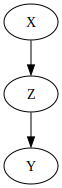

In [51]:
p = graphviz.Digraph()
p.edge('X','Z')
p.edge('Z','Y')
p

#### Collider

Nel campo delle relazioni causali, un collider è un particolare tipo di struttura in cui due variabili, diciamo $X$ e $Y$, influenzano una terza variabile, $Z$, ma non condividono cause comuni. In altre parole, $X$ e $Y$ non sono associate tra loro, ma entrambe hanno un effetto su $Z$.

Questa struttura può portare a situazioni complesse quando si tenta di analizzare le relazioni tra $X$ e $Y$. Ad esempio, se si stratifica il modello per $Z$, cioè se si prende in considerazione $Z$, può emergere un'associazione tra $X$ e $Y$ che in realtà non esiste nella popolazione. Questo fenomeno è noto come "bias del collider" e può sorgere da processi statistici o endogeni.

Immaginiano di voler studiare la relazione tra l'intelligenza ($X$) e la creatività ($Y$) di un gruppo di studenti. Inizialmente, non vi è alcuna relazione evidente tra queste due variabili: alcuni studenti sono molto intelligenti ma meno creativi, mentre altri sono molto creativi ma meno intelligenti. In altre parole, nella popolazione generale di studenti, non c'è nessuna associazione tra intelligenza e creatività.

Ora, immaginiamo che un prestigioso programma artistico selezioni gli studenti in base a una combinazione di intelligenza e creatività ($Z$). Per essere ammessi, gli studenti devono essere o estremamente intelligenti o estremamente creativi, o entrambi. Ma pochi studenti hanno valori elevate in entrambi gli aspetti.

Se analizzi solo gli studenti ammessi a questo programma (cioè, se condizioniamo i dati su $Z$), potremmo osservare una forte associazione negativa tra intelligenza e creatività. Questo accade perché la selezione nel programma funge da collider: gli studenti con intelligenza elevata tendono ad avere una creatività più bassa e viceversa, almeno tra quelli selezionati.

Questa associazione negativa è un artefatto della selezione e non riflette una relazione causale reale tra intelligenza e creatività. In effetti, tra gli studenti che non sono stati selezionati, non c'è alcuna associazione tra queste variabili. L'errore di condizionare su un collider (in questo caso, l'ammissione al programma) ha creato un'associazione "fantasma" tra intelligenza e creatività, che può portare a conclusioni errate se non si comprende la struttura sottostante delle relazioni causali.

Questo esempio evidenzia l'importanza di comprendere la struttura causale quando si analizzano le relazioni tra variabili, in particolare quando si utilizzano metodi statistici che possono essere sensibili a bias come quello del collider.

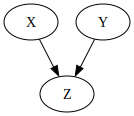

In [49]:
c = graphviz.Digraph()
c.edge('X','Z')
c.edge('Y','Z')
c

#### Il descendent

La nozione di "descendent" nelle relazioni causali può essere descritta attraverso una struttura gerarchica in cui una variabile influisce su un'altra, che a sua volta influisce su altre variabili. Nel diagramma dato, possiamo vedere che $X$ influisce su $Z$, e $Z$ influisce sia su $A$ che su $Y$. Qui, $A$ è un "descendent" di $Z$, e $Z$ è a sua volta un descendent di $X$.

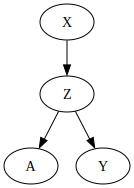

In [50]:
d = graphviz.Digraph()
d.edge('X','Z')
d.edge('Z','A')
d.edge('Z','Y')
d

Proviamo a spiegare questo concetto attraverso un esempio psicologico.

Immaginiamo un contesto lavorativo in cui stiamo esaminando tre aspetti chiave: l'istruzione di un individuo ($X$), le competenze sul lavoro ($Z$), e il successo professionale ($Y$). Inoltre, consideriamo la soddisfazione lavorativa ($A$) come un elemento che riflette le competenze sul lavoro.

1. **L'istruzione e le competenze sul lavoro**: Più elevata è l'istruzione di un individuo ($X$), migliori saranno le sue competenze sul lavoro ($Z$). Qui, l'istruzione è una causa diretta delle competenze sul lavoro.

2. **Le competenze sul lavoro e la soddisfazione lavorativa**: Le competenze sul lavoro ($Z$) non solo influenzano il successo professionale ($Y$) ma si riflettono anche nella soddisfazione lavorativa ($A$) dell'individuo.

3. **L'istruzione e il successo professionale**: L'istruzione ($X$) può portare al successo professionale ($Y$), ma questa relazione è mediata dalle competenze sul lavoro ($Z$). In altre parole, l'istruzione influisce sul successo lavorativo attraverso le competenze che essa genera.

Se vogliamo analizzare la relazione diretta tra l'istruzione e il successo professionale $Y$, dobbiamo essere cauti nell'includere la soddisfazione lavorativa ($A$) nel modello. Poiché $A$ è un "descendent" di $Z$, includerla significa includere indirettamente anche $Z$. In pratica, controllare per la soddisfazione lavorativa ci dà una visione parziale delle competenze sul lavoro, ma in un modo che potrebbe indebolire o alterare la nostra comprensione della relazione diretta tra l'istruzione e il successo professionale.

Questo concetto di "descendent" è estremamente importante in molti ambiti, come ad esempio le reti sociali, dove le connessioni tra individui possono creare catene di influenze indirette.

In conclusione, il concetto di "descendent" ci aiuta a comprendere come le relazioni causali possano essere complesse e interconnesse, richiedendo un'attenta considerazione nella modellazione e nell'analisi. La consapevolezza di come le variabili siano collegate in una struttura gerarchica può essere cruciale per una corretta interpretazione e per evitare conclusioni fuorvianti.

## Commenti e considerazioni finali

In questo capitolo, abbiamo esplorato il delicato legame tra correlazione e causalità, unendo il contesto dell'analisi descrittiva con modelli causalità più complessi come il "pipe", il "collider" e i "descendents". La correlazione ci offre un primo sguardo sulle relazioni tra variabili, ma come abbiamo visto, non sempre essa rivela le connessioni causali vere e proprie. Le strutture sottostanti che guidano queste relazioni possono essere intricate e richiedono un'analisi più approfondita. I modelli e gli esempi discussi sottolineano l'importanza di guardare oltre la semplice correlazione, accrescendo la nostra capacità di interpretare i dati e di evitare fraintendimenti comuni. In sintesi, mentre la correlazione rimane uno strumento essenziale nell'analisi dei dati, l'approfondimento delle relazioni causali sottostanti fornisce una visione più completa e accurata, essenziale per trarre conclusioni informate e robuste.

TODO Aggiungere la discussione sul fatto che è possibile inferire le relazioni causali da un DAG, controllando per le variabili di confondimento, solo quando il DAG è COMPLETO, ovvero quando non abbiamo escluso alcuna variabile dal DAG che influenza le variabili che sono incluse. Questo è un grande SE.

## Watermark

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Sep 08 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

numpy     : 1.25.2
scipy     : 1.11.2
matplotlib: 3.7.2
arviz     : 0.16.1
graphviz  : 0.20.1
seaborn   : 0.12.2
pandas    : 2.1.0

Watermark: 2.4.3

